In [ ]:
# Initialize Otter
import otter
grader = otter.Notebook("RBF networks.ipynb")

# Matrix Analysis 2024 - EE312
## Week 8 - Image classification with Radial Basis Function (RBF) networks
[LTS2](https://lts2.epfl.ch)

In [3]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import pairwise_distances
from scipy.spatial import distance_matrix
from scipy.special import softmax
import requests
from pathlib import Path

##  1. Image Classification
In this exercise, we will be doing image classification with a simple neural network. For simplicity, let's assume we will be working with black and white images.
Given an input image $i$ represented as a vector of  pixel intensities $ \mathbf{x}_i \in [0,1]^d$, we want to predict its correct label $\mathbf{y}_i$, which is represented as a one-hot vector in $\{0,1\}^K$, where $K$ is the number of possible categories (classes) that the image may belong to. For example, we may have pictures of cats and dogs, and our goal would be to correctly tag those images as either cat or dog. In that case we would have $K=2$, and the vectors $\begin{pmatrix}0 \\ 1\end{pmatrix}$ and $\begin{pmatrix}1 \\ 0\end{pmatrix}$ to represent the classes of cat and dog.  

In today's example we will be using the MNIST handwritten digit dataset. It contains images of handwritten numbers from 0 to 9 and our goal is to create a model that can accurately tag each image with its number. Let's load the data first.

In [4]:
### Load the data

# Download data if needed
if not Path("./mnist_data.npz").is_file():
    r = requests.get('https://os.unil.cloud.switch.ch/swift/v1/lts2-ee312/mnist_data.npz', allow_redirects=True)
    with open('mnist_data.npz', 'wb') as f: # save locally
        f.write(r.content)


mnist = np.load('mnist_data.npz')

In the context of classification, neural networks are models that given one (or multiple) input data points produce as output a set of corresponding labels for each input. The model itself consists of parametric functions $g_i$ which can be applied sequentially to the input data, resulting in a set of labels which are the model's prediction for the data. For example, in a model that consists of two parameteric functions $g_1$ and $g_2$, for a given $\mathbf{x}_i$, we have the predicted label $ \hat{\mathbf{y}}_i = g_1(g_2(\mathbf{x}_i))$. The parametric functions are commonly called "layers".

In a standard image classification setup, we are given some training data which we can use to tune the parameters of the parametric functions $g_i$ in order to improve its ability to predict the labels correctly. The parameters are generally tuned with respect to some objective (commonly called a loss function). We want to find the parameters of the model that minimize this loss function. Various loss functions can be used, but in general they tend to encode how "wrong" the model is. For
example, on a given image $i$ one can use the loss $\mathcal{L}(\hat{\mathbf{y}_i}, \mathbf{y}_i)= \sum_{j=1}^{K}(\hat{{y}}_{ij} -{y}_{ij})^2 $, which is the mean squared difference between the vector coordinates of the predicted label of the image and the ones of the actual label $\mathbf{y}_i$.
Minimizing the loss over the whole training set is referred to as "training the model". Furthermore, the goal is that given new data we have not seen before and we have not trained our model with, the model will still be able to classify accurately.

Before we go into the details of the model and how we will train it, let's prepare the data.

In [5]:
# Preprocess the data

images = mnist['data']
num_images = images.shape[0]

train_set_size = 60000
test_set_size = 10000

train_images = images[:train_set_size]
train_images = train_images/255.
train_images =  train_images

test_images = images[-test_set_size:]
test_images = test_images/255.
test_images = test_images

#create one-hot encodings of labels
mnist_target = mnist['target']
num_classes = mnist_target.max()+1
labels = []
for k in range(num_images):
    one_hot = np.zeros(num_classes)
    one_hot[int(mnist_target[k])]=1
    labels += [one_hot]
labels = np.array(labels)

#labels in one-hot
train_labels = labels[:train_set_size]
test_labels = labels[-test_set_size:]

#labels in integer form
int_labels = np.array(mnist_target, dtype=int)
int_labels_train = int_labels[:train_set_size]
int_labels_test = int_labels[-test_set_size:]

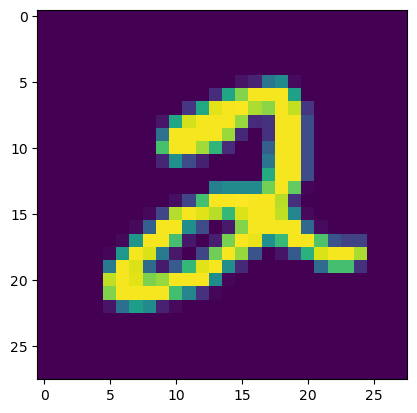

In [6]:
# View an image to make sure everything went well
which_one = 5
plt.imshow(train_images[which_one].reshape((28,28)));

## 2. Radial Basis Function (RBF) networks

For our task, we will be using Radial Basis Function (RBF) Networks as our neural network model.
The pipeline, which is presented in the image below, consists of two layers. The first employs non-linear functions $g_1(\mathbf{x};\boldsymbol{\mu}): \mathbb{R}^{n \times d} \rightarrow \mathbb{R}^{n \times c}$.
The second is a linear layer, represented by a matrix of weights $\mathbf{W} \in \mathbb{R}^{c \times K}$, which maps the output of the previous layer to class scores; its role is to predict labels. 

The pipeline proceeds in the following steps:

i) Choose a set of $c$ points $\boldsymbol{\mu}_j\in [0,1]^d$.     
ii) Compute $g_1(\mathbf{x}_i;\boldsymbol{\mu}_j) = \exp^{-\frac{||{\mathbf{x}_i-\boldsymbol{\mu}_j||^2}}{\sigma^2}}=a_{ij}$ for all possible pairs of $i$ and $j$. Here $\sigma$ is a hyperparameter that controls the width of the gaussian.  
iii) Compute the predicted labels $g_2(\mathbf{a}_i)= \mathbf{a}_i^{\top}\mathbf{W}= \hat{\mathbf{y}}_i$. Here $\mathbf{a}_i \in \mathbb{R}^c$ are the outputs of the layer $g_1$ for an input image $i$. $\hat{\mathbf{y}}_i$ is a row vector and $\hat{y}_{ij} = \sum_{m=1}^{c}a_{im}w_{mj}$, $j\in\{1,...,K\}$. 

![RBF_NN.png](images/RBF_NN.png)

Intuitively, the first layer of the RBF network can be viewed as matching the input data with a set of prototypes (templates) through a gaussian whose width is determined by $\sigma$. The second layer performs a weighted combination of the matching scores of the previous layer to determine the predicted label for a given point. 

**1.** For hyperparameters $c$ and $\sigma$ of your choice, select $c$ prototypes and obtain the output of the first layer of the RBF network. The prototypes can simply be random images from your training set.

The following functions might be helpful:
- [pairwise_distances (from scikit-learn)](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise_distances.html)
- [random.choice (from numpy)](https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html)

You can (optionally) perform an additional normalization step on the activations using the [softmax](https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.softmax.html) function.


In [7]:
def get_rand_centers(num_centers, imgs):
    """
    Sample num_centers (randomly) from imgs

    Parameters
    ----------
    num_centers : number of samples
    imgs : matrix to sample rows from

    Returns
    -------
    The samples matrix
    """
    # BEGIN SOLUTION
    num_imgs = imgs.shape[0]
    if num_centers > num_imgs or num_centers < 1:
        raise ValueError("Invalid number of centers requested")
    rand_center_indices = np.random.choice(num_imgs, size=num_centers, replace=False)
    rand_centers = imgs[rand_center_indices]
    return rand_centers
    # END SOLUTION
    
def get_activations(imgs, rand_centers, sigma, softmax_norm=False):
    """
    Computes the activations of the images vs. the sample centers

    Parameters
    ----------
    imgs: images matrix to compute activations for
    rand_centers: matrix of centers points
    sigma: parameter of the gaussian kernel
    softmax_norm: if true, perform softmax activation on the activations

    Returns
    -------
    The activation matrix A
    """
    # BEGIN SOLUTION
    # compute activations of the first layer
    if imgs.shape[1] != rand_centers.shape[1]:
        raise ValueError("Size mismatch between images/centers")
    distmat = pairwise_distances(imgs, rand_centers)

    activations = np.exp(-distmat*distmat/(sigma*sigma))

    # optional normalization step
    if softmax_norm:
        activations = softmax(activations, axis=1)
    return activations
    # END SOLUTION

In [61]:
#pick random centers
number_of_centers = 200

rand_centers = get_rand_centers(number_of_centers, train_images)

sigma = 10
activations = get_activations(train_images, rand_centers, sigma)

In [ ]:
grader.check("q1")

## 3. Training the network

To make things easier, we will fix the parameters $\boldsymbol{\mu}$ and $\sigma$ of the network, i.e., we decide their values before and the remain constant throughout training and testing of the model. Therefore, the only trainable parameters are going to be the weights of the second layer.
To train the model, we are going to use the mean squared loss function that we mentioned earlier. For a training dataset with $n$ images we have

$$ \mathcal{L}(\text{training data}, \text{training labels}) = \frac{1}{2n}\sum_{i=1}^n\mathcal{L}(\hat{\mathbf{y}}_i,\mathbf{y}_i) = \frac{1}{2n}\sum_{i=1}^n ||(\hat{\mathbf{y}}_{i} - \mathbf{y}_{i})||^2.$$




 There are two ways of tuning those:  
i) Backpropagation.   
ii) Solve a linear system.

### 3.1 Training with backpropagation

Backpropagation depends on [gradient descent](https://en.wikipedia.org/wiki/Gradient_descent#Description). The goal is to update the trainable parameters of the network by "moving them" in the direction that will decrease the loss function.
In our case, the weights $w_{kl}$ are updated in the following manner
$$ w_{kl}' = w_{kl}- \gamma \frac{\partial\mathcal{L}(\text{training data}, \text{training labels})}{\partial w_{kl}}, $$
where $\gamma$ is a hyper-parameter called the learning rate. The gradient of the Loss points towards the direction of steepest descent, hence we update the weights of the network towards that direction.  


---

<!-- BEGIN QUESTION -->

2. For the mean squared error loss, what is the gradient of the loss with respect to the weights $w_{kl}$ of the network?

_Type your answer here, replacing this text._

First let us expand the expression of the loss:

$\sum_{i=1}^n ||(\hat{\mathbf{y}}_{i} - \mathbf{y}_{i})||^2 = \sum_{i=1}^n \sum_{p=1}^K(\hat{\mathbf{y}}_{ip} - \mathbf{y}_{ip})^2$

The gradient of the loss with respect to the weights for a given input image can be calculated as
$$\frac{\partial \mathcal{L}(\hat{\mathbf{y}}_i,\mathbf{y}_i)}{\partial w_{kl}} =\frac{\partial \sum_{p=1}^K (\hat{y}_{ip}-y_{ip})^2}{\partial w_{kl}}=  \frac{ \sum_{p=1}^K \partial(\hat{y}_{ip}-y_{ip})^2}{\partial w_{kl}} = \sum_{p=1}^K 2(\hat{y}_{ip}-y_{ip})\frac{ \partial\hat{y}_{ip}}{\partial w_{kl}}.  $$

If we expand $\hat{y}_{ip} = \sum_{m=1}^{c}a_{im}w_{mp}$ in the partial derivative, this leads to :

$\frac{\partial \mathcal{L}(\hat{\mathbf{y}}_i,\mathbf{y}_i)}{\partial w_{kl}} = \sum_{p=1}^K 2(\hat{y}_{ip}-y_{ip})\frac{ \partial\sum_{m=1}^{c}a_{im}w_{mp}}{\partial w_{kl}} = \sum_{p=1}^K 2(\hat{y}_{ip}-y_{ip})\sum_{m=1}^{c}a_{im}\frac{ \partial w_{mp}}{\partial w_{kl}}$.

The term $\frac{ \partial w_{mp}}{\partial w_{kl}}$ is always zero except when $p=l$ and $m=k$, therefore:

$\frac{\partial \mathcal{L}(\hat{\mathbf{y}}_i,\mathbf{y}_i)}{\partial w_{kl}} = 2(\hat{y}_{il}-y_{il})a_{ik}$.


<!-- END QUESTION -->

3. Train the weights of the linear layer using stochastic gradient descent. For $p$ iterations (called epochs), you have to update each weight $w_{kl}$ of the network once for each image, by computing the gradient of the loss with respect to that weight.

NB: if you implement gradient computation naively, it might be very slow. Consider using [numpy.outer](https://numpy.org/doc/stable/reference/generated/numpy.outer.html) to speed up computation.


In [16]:
# Helper function to compute the loss
def get_predictions_loss(activations, weight, labels, int_labels):
    predictions = activations@weights
    num_correct_predictions = ((predictions.argmax(1) - int_labels)==0).sum()
    loss = ((predictions - labels)*(predictions - labels)).sum(1).mean()
    return loss, num_correct_predictions

In [66]:
# compute the gradient for a single input
def compute_gradient(activation, weights, train_label):
    """
    Computes gradients of the weight for a single activation

    Parameters
    ----------
    activation : vector containing the activation of the current image
    weights: current weights
    train_label: label of the current image

    Returns
    -------
    The gradient to update the weights 
    """
    # BEGIN SOLUTION
    prediction = activation@weights # denoted as \hat{y} in the text
    delta = prediction - train_label
    grad = np.outer(delta, activation).T
    # the above line is a much faster shortcut for :
    #grad = np.zeros(weights.shape)
    #for k in range(grad.shape[0]):
    #    grad[k, :] = 2*delta*activation[k]
    return grad
    # END SOLUTION

In [ ]:
# Initial values for hyperparams. Feel free to experiment with them.
weights = (1/28)*np.random.randn(number_of_centers, num_classes)
epochs = 5 # you should train for more epochs !
learning_rate = 0.1

#Backpropagation with SGD
for k in range(epochs):
    for counter, activation in enumerate(activations):
        gradient = compute_gradient(activation, weights, train_labels[counter])/(2*train_set_size) # SOLUTION
        weights = weights - learning_rate*gradient # SOLUTION
    
    loss_train, num_correct_predictions_train = get_predictions_loss(activations, weights, train_labels, int_labels_train)
    print("Loss:", loss_train)
    print("Number of correct predictions:", num_correct_predictions_train)

In [ ]:
grader.check("q3")

We can now check how well your network does on the test set and print its accuracy.

In [88]:
def get_accuracy(predictions, int_labels, set_size):
    num_correct_predictions = ((predictions.argmax(1) - int_labels)==0).sum()
    return num_correct_predictions/set_size

test_activations = get_activations(test_images, rand_centers, sigma)
test_predictions = test_activations@weights
print(f"The accuracy on the test set is: {get_accuracy(test_predictions, int_labels_test, test_set_size)*100} %")  

The accuracy on the test set is: 50.73 %


### 3.2 Solving the linear system

Since we only have one weight matrix to tune, we can avoid learning with backpropagation entirely. Consider the mean squared error for the whole dataset and a one-dimensional binary label $y_i$ for each data point for simplicity. The mean squared loss for the dataset is
$$  \sum_{i=1}^n (\hat{{y}}_{i} - {y}_{i})^2=  ||(\mathbf{A}\mathbf{w} - \mathbf{y})||^2.$$ Here $\mathbf{A} \in \mathbb{R}^{n \times c}$ is the matrix that contains the outputs (activations) of the first layer. From a linear algebra perspective, we are looking for a matrix $\mathbf{w}$ that solves the linear system $ \mathbf{A}\mathbf{w} = \mathbf{y}.$  


---

<!-- BEGIN QUESTION -->

4. Can we find solutions to this system (justify) and how ?

_Type your answer here, replacing this text._

The system is overdetermined. We have more equations (1 equation per data point) than unknown variables (1 variable for each template). We can find approximate solutions with a [least squares](https://en.wikipedia.org/wiki/Overdetermined_system#Approximate_solutions) approach, i.e., using the pseudoinverse.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

5. Based on your answer above, compute the weights of the neural network that best classify the data points of the training set.

_Type your answer here, replacing this text._

In [89]:
#calculate the weights of the linear layer
weights_lsq = np.linalg.pinv(activations)@train_labels # SOLUTION

Using the weights you computed, classify the points in the training set and print the accuracy.

In [90]:
#predict the labels of each image in the training set and compute the accuracy
train_prediction_lsq = activations@weights_lsq # SOLUTION
print(f"The accuracy on the training set is: {get_accuracy(train_prediction_lsq, int_labels_train, train_set_size)*100} %")

The accuracy on the training set is: 91.43 %


Using the weights you computed, classify the points in the test set and print the accuracy.

In [91]:
#calculate the activations of the test set
test_activations = get_activations(test_images, rand_centers, sigma)

In [92]:
#predict the accuracy on the test set
test_predictions_lsq = test_activations@weights_lsq # SOLUTION
print(f"The accuracy on the test set is: {get_accuracy(test_predictions_lsq, int_labels_test, test_set_size)*100} %")

The accuracy on the test set is: 91.75 %


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### 6. **Open ended**: On the choice of templates. 
Suggest a different or more refined way to select templates for the RBF network and implement it. Check how it compares with your original approach.
Check how it works with the backpropagation and linear system solutions.

_Type your answer here, replacing this text._

Here are a few things that can be tried in order to better select the template images:

- split up the images based on label and sample an equal amount of images from each class.  This ensures that there won't be imbalances in the representations of templates/centers.
- split up the images based on label and furthermore subdivide the images of each class into a few groups. Compute the average image in each group. You will have a few "average images" in each class. Use those as centroids/templates. (All of this averaging stuff is easily done with matrix ops)
- filter the images (similar to how it was done in previous notebooks) and then sample extra centers from the filtered data. Use those as additional centers.
- apply standard clustering techniques like [K-Means](https://en.wikipedia.org/wiki/K-means_clustering) and [Spectral Clustering](https://en.wikipedia.org/wiki/Spectral_clustering)

<!-- END QUESTION -->

